# Inference with Approximate Bayesian Computation (ABC)

In [1]:
import argparse
import os
import pickle
from functools import partial
from typing import Union

import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import numpy as np
import pyabc
#from pyabc.sampler import RedisEvalParallelSampler
import scipy.stats as stats
import umap
from fitmulticell import model as morpheus_model
from fitmulticell.sumstat import SummaryStatistics
from matplotlib.patches import Patch

from load_bayesflow_model import load_model, EnsembleTrainer
from plotting_routines import sampling_parameter_cis, plot_posterior_1d, plot_posterior_2d, plot_sumstats_distance_hist, plot_sumstats_distance_stats
from summary_stats import compute_summary_stats, reduce_to_coordinates, span, euclidean_distance

In [2]:
# load real data in morpheus format
from load_data import load_real_data

test_params = None
results_path = 'abc_results_real'

In [3]:
# get the job array id and number of processors
n_procs = 10 # int(os.environ.get('SLURM_CPUS_PER_TASK', 1))
on_cluster = False
population_size = 1000

if on_cluster:
    parser = argparse.ArgumentParser(description='Parse necessary arguments')
    parser.add_argument('-pt', '--port', type=str, default="50004",
                        help='Which port should be use?')
    parser.add_argument('-ip', '--ip', type=str,
                        help='Dynamically passed - BW: Login Node 3')
    args = parser.parse_args()

In [4]:
if on_cluster:
    gp = '/home/jarruda_hpc/CellMigration/synth_data_params_bayesflow'
else:
    gp = os.getcwd()

par_map = {
    'gradient_strength': './CellTypes/CellType/Constant[@symbol="gradient_strength"]',
    'move.strength': './CellTypes/CellType/Constant[@symbol="move.strength"]',
    'move.duration.mean': './CellTypes/CellType/Constant[@symbol="move.duration.mean"]',
    'cell_nodes_real': './Global/Constant[@symbol="cell_nodes_real"]',
}

dt = 30
model_path = gp + "/cell_movement_v24.xml"  # time step is 30sec, for inference

# defining the summary statistics function
min_sequence_length = 0
max_sequence_length = 3600 // dt
only_longest_traj_per_cell = True  # mainly to keep the data batchable
cells_in_population = 143

# defining the summary statistics function
def make_sumstat_dict(data: Union[dict, np.ndarray]) -> dict:
    if isinstance(data, dict):
        # get key
        key = list(data.keys())[0]
        data = data[key]
    data = data[0]  # only one full simulation
    assert data.ndim == 3
    # compute the summary statistics
    msd_list, ta_list, v_list, ad_list = compute_summary_stats(data, dt=dt)
    cleaned_dict = {
        'msd': np.array(msd_list).flatten(),
        'ta': np.array(ta_list).flatten(),
        'vel': np.array(v_list).flatten(),
        'ad': np.array(ad_list).flatten(),
    }
    return cleaned_dict


def prepare_sumstats(output_morpheus_model) -> dict:
    sim_coordinates = reduce_to_coordinates(output_morpheus_model, 
                          minimal_length=min_sequence_length, 
                          maximal_length=max_sequence_length,
                          only_longest_traj_per_cell=only_longest_traj_per_cell,
                          )
    
    # we now do exactly the same as in the BayesFlow workflow, but here we get only one sample at a time
    data_transformed = np.ones((1, cells_in_population, max_sequence_length, 3)) * np.nan
    # each cell is of different length, each with x and y coordinates, make a tensor out of it
    if len(sim_coordinates) != 0:
        # some cells were visible in the simulation
        for c_id, cell_sim in enumerate(sim_coordinates):
            # pre-pad the data with zeros, but first write zeros as nans to compute the mean and std
            data_transformed[0, c_id, -len(cell_sim['x']):, 0] = cell_sim['x']
            data_transformed[0, c_id, -len(cell_sim['y']):, 1] = cell_sim['y']
            data_transformed[0, c_id, -len(cell_sim['t']):, 2] = cell_sim['t']
    
    return {'sim': data_transformed}


sumstat = SummaryStatistics(sum_stat_calculator=prepare_sumstats)                    

if on_cluster:
    # define the model object
    model = morpheus_model.MorpheusModel(
        model_path, par_map=par_map, par_scale="log10",
        show_stdout=False, show_stderr=False,
        executable="ulimit -s unlimited; /home/jarruda_hpc/CellMigration/morpheus-2.3.7",
        clean_simulation=True,
        raise_on_error=False, sumstat=sumstat)

    # note: remember also change tiff path in model.xml!
else:
    # define the model object
    model = morpheus_model.MorpheusModel(
        model_path, par_map=par_map, par_scale="log10",
        show_stdout=False, show_stderr=False,
        clean_simulation=True,
        raise_on_error=False, sumstat=sumstat)

# parameter values used to generate the synthetic data
obs_pars = {
    'gradient_strength': 100.,  # strength of the gradient of chemotaxis
    'move.strength': 10.,  # strength of directed motion
    'move.duration.mean': 0.1,  # mean of exponential distribution (seconds)
    'cell_nodes_real': 50.,  # area of the cell (\mu m^2), macrophages have a volume of 4990\mu m^3 -> radius of 17 if they would are sphere
}


obs_pars_log = {key: np.log10(val) for key, val in obs_pars.items()}
limits = {'gradient_strength': (1, 10000), #(10 ** 4, 10 ** 8),
          'move.strength': (1, 100),
          'move.duration.mean': (1e-4, 30), #(math.log10((10 ** -2) * 30), math.log10((10 ** 4))), # smallest time step in simulation 5
          'cell_nodes_real': (1, 300)}
limits_log = {key: (np.log10(val[0]), np.log10(val[1])) for key, val in limits.items()}


prior = pyabc.Distribution(**{key: pyabc.RV("uniform", loc=lb, scale=ub-lb)
                              for key, (lb, ub) in limits_log.items()})
param_names = ['$m_{\\text{dir}}$', '$m_{\\text{rand}}$', '$w$', '$a$']
log_param_names = ['$\log_{10}(m_{\\text{dir}})$', '$\log_{10}(m_{\\text{rand}})$',
                   '$\log_{10}(w)$', '$\log_{10}(a)$']
print(obs_pars)
print(limits_log)

{'gradient_strength': 100.0, 'move.strength': 10.0, 'move.duration.mean': 0.1, 'cell_nodes_real': 50.0}
{'gradient_strength': (0.0, 4.0), 'move.strength': (0.0, 2.0), 'move.duration.mean': (-4.0, 1.4771212547196624), 'cell_nodes_real': (0.0, 2.4771212547196626)}


In [5]:
prior_draws = np.array([list(prior.rvs().values()) for _ in range(1000)])

In [6]:
def obj_func_wass_helper(sim: dict, obs: dict, key: str) -> float:
    x, y = np.array(sim[key]), np.array(obs[key])
    if x.size == 0 or y.size == 0:
        return np.inf
    return stats.wasserstein_distance(x, y)

distances = {
    'msd': pyabc.distance.FunctionDistance(partial(obj_func_wass_helper, key='msd')),
    'ta': pyabc.distance.FunctionDistance(partial(obj_func_wass_helper, key='ta')),
    'vel': pyabc.distance.FunctionDistance(partial(obj_func_wass_helper, key='vel')),
    'ad': pyabc.distance.FunctionDistance(partial(obj_func_wass_helper, key='ad')),
}

# adaptive distance
log_file_weights = f"{results_path}/adaptive_distance_log_real.txt"

adaptive_wasserstein_distance = pyabc.distance.AdaptiveAggregatedDistance(
    distances=list(distances.values()),
    scale_function=span,
    log_file=log_file_weights
)

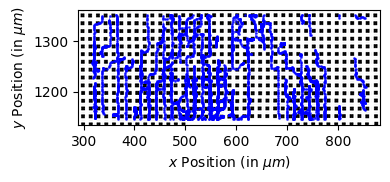

In [7]:
_, real_data_full = load_real_data(data_id=1,
                                   max_sequence_length=max_sequence_length,
                                   cells_in_population=cells_in_population)
real_sim = real_data_full[np.newaxis]

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True,
                       tight_layout=True, figsize=(4, 3))

plt.plot(real_data_full[0, :, 0], real_data_full[0, :, 1], color='blue', alpha=0.7)
for cell_id in range(1, real_data_full.shape[0]):
    plt.plot(real_data_full[cell_id, :, 0], real_data_full[cell_id, :, 1],
             linewidth=0.5, color='blue', alpha=0.7)
    plt.scatter(real_data_full[cell_id, :, 0], real_data_full[cell_id, :, 1],
                s=1, color='blue', alpha=0.7)

lims = ax.get_xlim(), ax.get_ylim()
img_path = 'Cell_migration_grid_v3_final2_invers.tiff'
img = plt.imread(img_path)
ax.imshow(img,
          origin='lower',
          #extent=[x_min, x_max, y_min, y_max],
          aspect='auto',          # preserve pixel squares
          zorder=0,
          interpolation=['bicubic', 'bessel', 'hermite', 'nearest', 'spline16', 'mitchell', 'bilinear', 'sinc', 'none', 'gaussian', 'blackman', 'spline36', 'hanning', 'kaiser', 'lanczos', 'antialiased', 'hamming', 'catrom', 'quadric'][14]) # keep grid sharp
ax.set_xlim(lims[0])
ax.set_ylim(lims[1])
ax.set_aspect('equal')

plt.ylabel('$y$ Position (in $\mu m$)')
plt.xlabel('$x$ Position (in $\mu m$)')
#plt.savefig(f'{results_path}/real_data.pdf', bbox_inches='tight')
plt.show()

# Real Data Analysis

In [8]:
#redis_sampler = RedisEvalParallelSampler(host=args.ip, port=args.port,
#                                         adapt_look_ahead_proposal=False,
#                                         look_ahead=False)

abc = pyabc.ABCSMC(model, prior,
                   distance_function=adaptive_wasserstein_distance,
                   summary_statistics=make_sumstat_dict,
                   population_size=population_size,
                   sampler=pyabc.sampler.MulticoreEvalParallelSampler(n_procs=n_procs)
                   #sampler=redis_sampler
                   )

db_path = os.path.join(gp, f"{results_path}/real_test_wasserstein_sumstats_adaptive.db")
if not os.path.exists(db_path):
    history_abc_real = abc.new("sqlite:///" + db_path, make_sumstat_dict(real_sim))

    # start the abc fitting
    abc.run(min_acceptance_rate=1e-2, max_nr_populations=15)
    print('Done!')
    adaptive_weights_real = pyabc.storage.load_dict_from_json(log_file_weights)[history_abc_real.max_t]
else:
    history_abc_real = abc.load("sqlite:///" + db_path)
    if len(history_abc_real.all_runs()) > 1:
        # first run failed
        history_abc_real = abc.load("sqlite:///" + db_path, abc_id=len(history_abc_real.all_runs()))
    adaptive_weights_real = pyabc.storage.load_dict_from_json(log_file_weights)[history_abc_real.max_t]

ABC.Sampler INFO: Parallelize sampling on 10 processes.
INFO:ABC.Sampler:Parallelize sampling on 10 processes.


In [9]:
if os.path.exists(os.path.join(gp, 'validation_data.pickle')):
    with open(os.path.join(gp, 'validation_data.pickle'), 'rb') as f:
        valid_data = pickle.load(f)
else:
    raise FileNotFoundError('Validation data not found')

x_mean = np.nanmean(valid_data['sim_data'], axis=(0, 1, 2))
x_std = np.nanstd(valid_data['sim_data'], axis=(0, 1, 2))
p_mean = np.mean(valid_data['prior_draws'], axis=0)
p_std = np.std(valid_data['prior_draws'], axis=0)
print('Mean and std of data:', x_mean, x_std)
print('Mean and std of parameters:', p_mean, p_std)

Mean and std of data: [ 587.005762   1226.92493169 7429.6348269 ] [   51.40666089    60.50555913 11194.06615154]
Mean and std of parameters: [ 1.94728187  0.99232727 -1.42390959  1.33567736] [1.15397718 0.60574734 1.50789037 0.69434402]


In [10]:
# use trained neural net as summary statistics
def make_sumstat_dict_nn(data: Union[dict, np.ndarray], use_npe_summaries: bool = True) -> dict:
    if use_npe_summaries:
        model_id = 2
    else:
        model_id = 10
    if isinstance(data, dict):
        # get key
        key = list(data.keys())[0]
        data = data[key]

    trainer = load_model(
        model_id=model_id,
        x_mean=x_mean,
        x_std=x_std,
        p_mean=p_mean,
        p_std=p_std,
    )

    # configures the input for the network
    config_input = trainer.configurator({"sim_data": data})
    # get the summary statistics
    if isinstance(trainer, EnsembleTrainer):
        out_dict = {
            'summary_net': trainer.amortizer.summary_net(config_input).flatten()
        }
    else:
        out_dict = {
            'summary_net': trainer.amortizer.summary_net(config_input['summary_conditions']).numpy().flatten()
        }
    if model_id == 10:
        # renormalize the parameters
        out_dict['summary_net'] = out_dict['summary_net'] * p_std + p_mean

    del trainer
    return out_dict


if on_cluster:
    # define the model object
    model_nn = morpheus_model.MorpheusModel(
        model_path, par_map=par_map, par_scale="log10",
        show_stdout=False, show_stderr=False,
        executable="ulimit -s unlimited; /home/jarruda_hpc/CellMigration/morpheus-2.3.7",
        clean_simulation=True,
        raise_on_error=False, sumstat=sumstat)

    # note: remember also change tiff path in model.xml!
else:
    # define the model object
    model_nn = morpheus_model.MorpheusModel(
        model_path, par_map=par_map, par_scale="log10",
        show_stdout=False, show_stderr=False,
        clean_simulation=True,
        raise_on_error=False, sumstat=sumstat)

In [11]:
#redis_sampler = RedisEvalParallelSampler(host=args.ip, port=args.port,
#                                         adapt_look_ahead_proposal=False,
#                                         look_ahead=False)

# abc with summary net trained with NPE
abc_npe = pyabc.ABCSMC(model_nn, prior, # here we use now the Euclidean distance, Wasserstein distance is not possible
                      population_size=population_size,
                      summary_statistics=partial(make_sumstat_dict_nn, use_npe_summaries=True),
                      sampler=pyabc.sampler.MulticoreEvalParallelSampler(n_procs=n_procs)
                      #sampler=redis_sampler
                      )

db_path = os.path.join(gp, f"{results_path}/real_test_nn_sumstats.db")
if not os.path.exists(db_path):
    history_npe_real = abc_npe.new("sqlite:///" + db_path,
                              make_sumstat_dict_nn(real_sim, use_npe_summaries=True))
    # start the abc fitting
    abc_npe.run(min_acceptance_rate=1e-2, max_nr_populations=15)
    print('Done!')
else:
    history_npe_real = abc_npe.load("sqlite:///" + db_path)
    if len(history_npe_real.all_runs()) > 1:
        # first run failed
        history_npe_real = abc_npe.load("sqlite:///" + db_path, abc_id=len(history_npe_real.all_runs()))

ABC.Sampler INFO: Parallelize sampling on 10 processes.
INFO:ABC.Sampler:Parallelize sampling on 10 processes.


abc


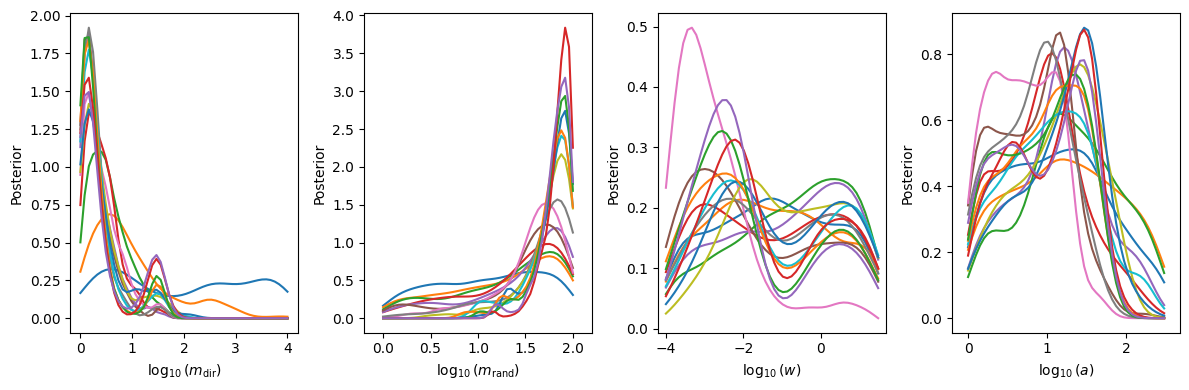

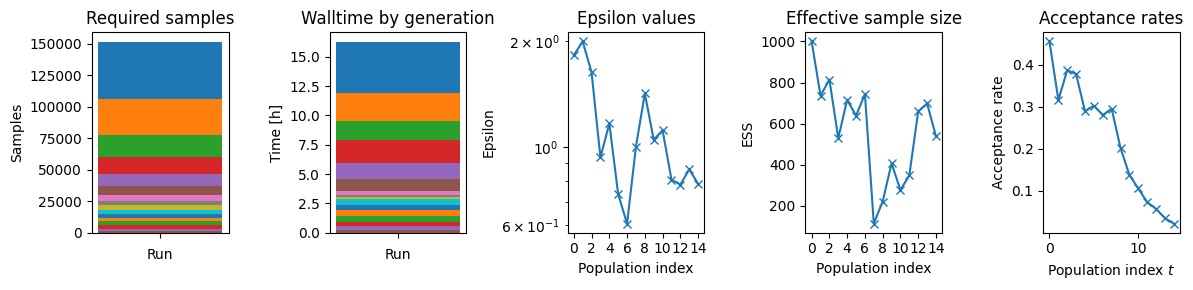

abc_npe


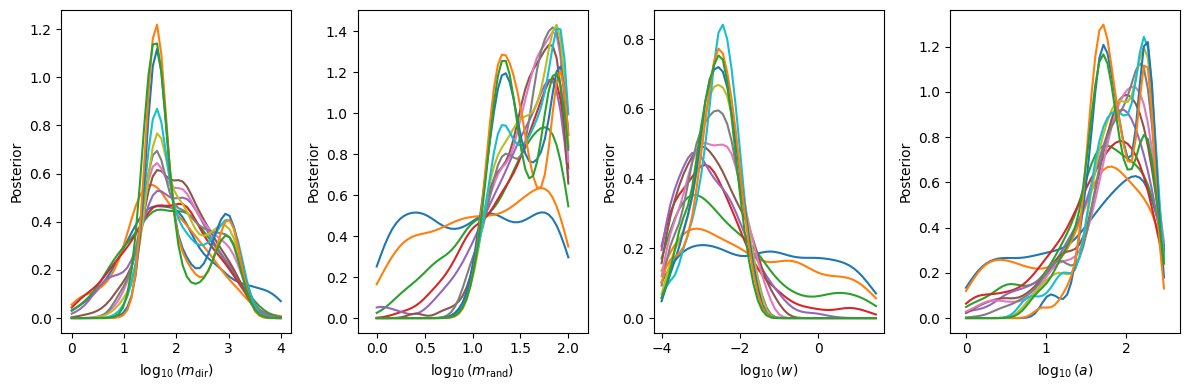

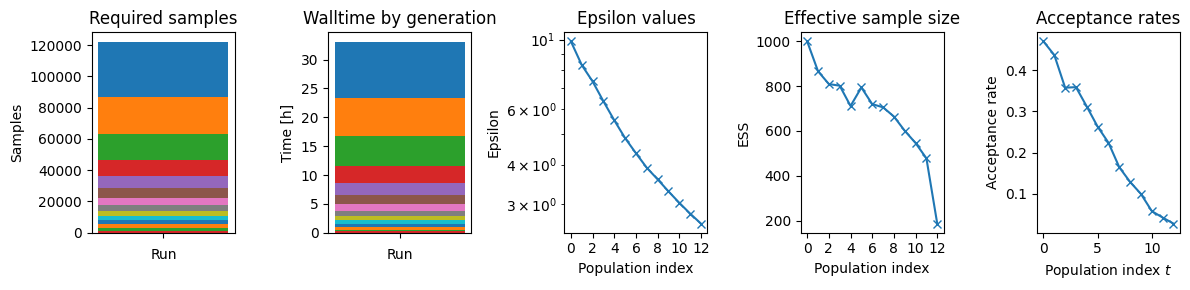

In [12]:
for hist, name in zip([history_abc_real, history_npe_real], ['abc', 'abc_npe']):
    if hist is None:
        continue
    print(name)
    fig, ax = plt.subplots(1, len(param_names), tight_layout=True, figsize=(12, 4))
    for i, param in enumerate(limits.keys()):
        for t in range(hist.max_t + 1):
            df, w = hist.get_distribution(m=0, t=t)
            pyabc.visualization.plot_kde_1d(
                df,
                w,
                xmin=limits_log[param][0],
                xmax=limits_log[param][1],
                x=param,
                xname=log_param_names[i],
                ax=ax[i],
                label=f"PDF t={t}",
            )
        ax[i].set_xlim((limits_log[param][0]-0.2, limits_log[param][1]+0.2))
    plt.savefig(os.path.join(gp, f'{results_path}/real_population_kdes_{name}.pdf'))
    plt.show()

    fig, arr_ax = plt.subplots(1, 5, figsize=(12, 3), tight_layout=True)
    arr_ax = arr_ax.flatten()
    pyabc.visualization.plot_sample_numbers(hist, ax=arr_ax[0])
    arr_ax[0].get_legend().remove()
    pyabc.visualization.plot_walltime(hist, ax=arr_ax[1], unit='h')
    arr_ax[1].get_legend().remove()
    pyabc.visualization.plot_epsilons(hist, ax=arr_ax[2])
    pyabc.visualization.plot_effective_sample_sizes(hist, ax=arr_ax[3])
    pyabc.visualization.plot_acceptance_rates_trajectory(hist, ax=arr_ax[4])
    plt.savefig(os.path.join(gp, f'{results_path}/real_diagnostics_{name}.pdf'))
    plt.show()

In [13]:
# get posterior samples
posterior_samples = {}
for hist, name in zip([history_abc_real, history_npe_real], ['abc', 'abc_npe']):
    if hist is None:
        continue
    abc_df, abc_w = hist.get_distribution()
    posterior_samples[name] = pyabc.resample(abc_df[limits.keys()].values, abc_w, n=1000)

# add bayesflow posterior samples
posterior_samples['npe'] = np.load(f'abc_results_real/posterior_samples_npe.npy')
posterior_samples['npe_ensemble'] = np.load(f'abc_results_real/posterior_samples_npe_ensemble.npy')

In [14]:
#np.save('abc_results_real/posterior_samples.npy', posterior_samples['npe'])

In [15]:
labels_colors = {
    'abc': ('ABC with hand-crafted summaries', '#9AB8D7'),
    'abc_npe': ('ABC with inference-tailored summaries', '#EEBC88'),
    'npe': ('NPE with jointly learned summaries', '#A7CE97'),
    'npe_ensemble': ('NPE-Ensemble', '#8EB699')
}

colors = [labels_colors[name][1] for name in posterior_samples.keys()]
labels = [labels_colors[name][0] for name in posterior_samples.keys()]

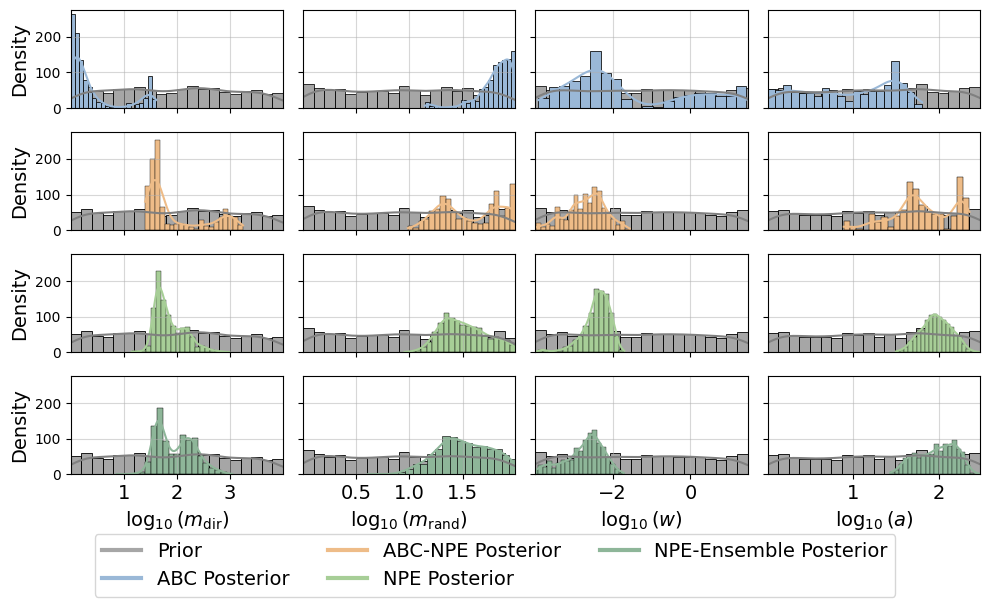

In [16]:
fig = plot_posterior_1d(
    posterior_samples=posterior_samples,
    prior_draws=prior_draws,
    log_param_names=log_param_names,
    test_sim=real_sim,
    test_params=None,
    labels_colors=labels_colors,
    make_sumstat_dict_nn=make_sumstat_dict_nn,
    save_path=os.path.join(gp, f'{results_path}/real_posterior_all_rows.pdf')
)

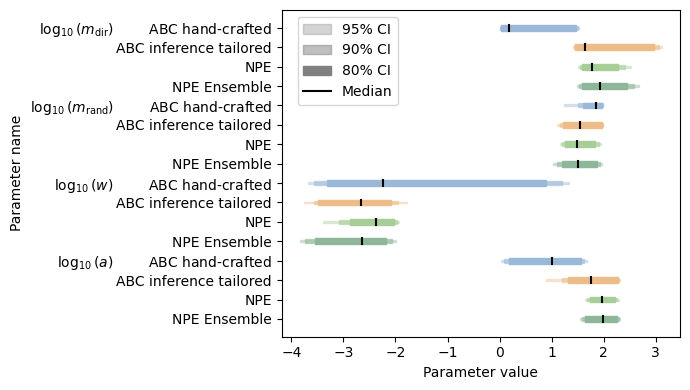

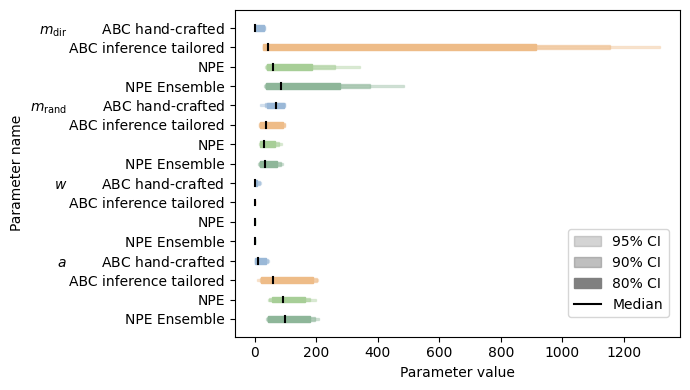

In [17]:
ordering = np.concatenate([[i,i+4, i+8, i+12] for i in range(4)])
all_params = np.concatenate((posterior_samples['abc'],
                             posterior_samples['abc_npe'],
                             posterior_samples['npe'],
                             posterior_samples['npe_ensemble']), axis=-1)
log_param_names_plot = np.array(
    [f'{n} $\qquad$ ABC hand-crafted' for n in log_param_names] +
    [f'ABC inference tailored' for n in log_param_names] +
    [f'NPE' for n in log_param_names] +
    [f'NPE Ensemble' for n in log_param_names]
)[ordering]
param_names_plot = np.array(
    [f'{n} $\qquad$ ABC hand-crafted' for n in param_names] +
    [f'ABC inference tailored' for n in param_names] +
    [f'NPE' for n in param_names] +
    [f'NPE Ensemble' for n in param_names]
)[ordering]
color_list = colors*len(param_names)

ax = sampling_parameter_cis(
    all_params[:, ordering],
    true_param=np.concatenate((test_params, test_params, test_params, test_params))[ordering] if test_params is not None else None,
    prior_bounds=limits_log.values() if test_params is not None else None,
    param_names=log_param_names_plot,
    alpha=[95, 90 , 80],
    color_list=color_list,
    show_median=False if test_params is not None else True,
    size=(7, 4),
    legend_bbox_to_anchor=(0.45,1) if test_params is not None else (0.31,1)
)
plt.savefig(os.path.join(gp, f'{results_path}/real_posterior_credible_intervals_log.pdf'))
plt.show()

all_params = np.power(10, all_params)
ax = sampling_parameter_cis(
    all_params[:, ordering],
    true_param=np.power(10, np.concatenate((test_params, test_params, test_params, test_params))[ordering]) if test_params is not None else None,
    param_names=param_names_plot,
    alpha=[95, 90 , 80],
    color_list=color_list,
    show_median=False if test_params is not None else True,
    size=(7, 4),
    legend_bbox_to_anchor=(0.99,0.35)
)
plt.savefig(os.path.join(gp, f'{results_path}/real_posterior_credible_intervals.pdf'))
plt.show()

In [ ]:
file_name = os.path.join(gp, f'{results_path}/real_posterior_simulations.pickle')
if os.path.exists(file_name):
    with open(file_name, 'rb') as f:
        posterior_simulations = pickle.load(f)
else:
    posterior_simulations = {}
    for name, ps in posterior_samples.items():
        @delayed
        def wrapper_fun(sample_i):
            _sim_dict = {key: p for key, p in zip(obs_pars.keys(), ps[sample_i])}
            _posterior_sim = model(_sim_dict)
            return _posterior_sim['sim']

        sim_list = Parallel(n_jobs=n_procs, verbose=1)(wrapper_fun(i) for i in range(10))
        posterior_simulations[name] = np.concatenate(sim_list)

    with open(file_name, 'wb') as f:
        pickle.dump(posterior_simulations, f)

simulation_sumstats = {}
for name, ps in posterior_simulations.items():
    simulation_sumstats[name] = [make_sumstat_dict(p_sim[np.newaxis]) for p_sim in ps]
    for i in range(len(simulation_sumstats[name])):
        simulation_sumstats[name][i]['nn'] = make_sumstat_dict_nn(ps[i][np.newaxis], use_npe_summaries=True)['summary_net']

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True,
                       tight_layout=True, figsize=(4, 3))

plt.plot(real_data_full[0, :, 0], real_data_full[0, :, 1], color='blue', alpha=0.7)
for cell_id in range(1, real_data_full.shape[0]):
    plt.plot(real_data_full[cell_id, :, 0], real_data_full[cell_id, :, 1],
             linewidth=0.5, color='blue', alpha=0.7)
    plt.scatter(real_data_full[cell_id, :, 0], real_data_full[cell_id, :, 1],
                s=1, color='blue', alpha=0.7)

lims = ax.get_xlim(), ax.get_ylim()
img_path = 'Cell_migration_grid_v3_final2_invers.tiff'
img = plt.imread(img_path)
ax.imshow(img,
          origin='lower',
          #extent=[x_min, x_max, y_min, y_max],
          aspect='auto',          # preserve pixel squares
          zorder=0,
          interpolation=['bicubic', 'bessel', 'hermite', 'nearest', 'spline16', 'mitchell', 'bilinear', 'sinc', 'none', 'gaussian', 'blackman', 'spline36', 'hanning', 'kaiser', 'lanczos', 'antialiased', 'hamming', 'catrom', 'quadric'][14]) # keep grid sharp
ax.set_xlim(lims[0])
ax.set_ylim(lims[1])
ax.set_aspect('equal')

plt.ylabel('$y$ Position (in $\mu m$)')
plt.xlabel('$x$ Position (in $\mu m$)')
plt.show()

In [ ]:
for name, ps in posterior_simulations.items():
    print(name)
    ps = ps[0]
    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True,
                           tight_layout=True, figsize=(4, 3))

    plt.plot(ps[0, :, 0], ps[0, :, 1], color='blue', alpha=0.7)
    for cell_id in range(1, ps.shape[0]):
        plt.plot(ps[cell_id, :, 0], ps[cell_id, :, 1],
                 linewidth=0.5, color='blue', alpha=0.7)
        plt.scatter(ps[cell_id, :, 0], ps[cell_id, :, 1],
                    s=1, color='blue', alpha=0.7)

    lims = ax.get_xlim(), ax.get_ylim()
    img_path = 'Cell_migration_grid_v3_final2_invers.tiff'
    img = plt.imread(img_path)
    ax.imshow(img,
              origin='lower',
              #extent=[x_min, x_max, y_min, y_max],
              aspect='auto',          # preserve pixel squares
              zorder=0,
              interpolation=['bicubic', 'bessel', 'hermite', 'nearest', 'spline16', 'mitchell', 'bilinear', 'sinc', 'none', 'gaussian', 'blackman', 'spline36', 'hanning', 'kaiser', 'lanczos', 'antialiased', 'hamming', 'catrom', 'quadric'][14]) # keep grid sharp
    ax.set_xlim(0, 1120)
    ax.set_ylim(0, 1700)
    ax.set_aspect('equal')

    plt.ylabel('$y$ Position (in $\mu m$)')
    plt.xlabel('$x$ Position (in $\mu m$)')
    plt.show()

In [ ]:
def obj_func_comparison(sim: dict, obs: dict, return_marginal: bool = False, weights: Union[dict, list] = None) -> Union[float, np.ndarray]:
    total = np.zeros(len(sim.keys()))
    for k_i, key in enumerate(sim):
        if key == 'nn':
            # for the neural network summary statistics we use the Euclidean distance
            total[k_i] = euclidean_distance(sim['nn'], obs['nn'])
            continue # no weights applied
        else:
            total[k_i] = distances[key](sim, obs)
        if weights is not None:
            if isinstance(weights, dict):
                total[k_i] = total[k_i] * weights[key]
            elif isinstance(weights, list):
                total[k_i] = total[k_i] * weights[k_i]
            else:
                raise ValueError('Weights must be a list or a dictionary')
    if return_marginal:
        return total
    return total.sum()

In [ ]:
real_sim_dict = make_sumstat_dict(real_sim)
real_sim_dict['nn'] = make_sumstat_dict_nn(real_sim, use_npe_summaries=True)['summary_net']

In [ ]:
plot_sumstats_distance_stats(obj_func_comparison,
                             real_sim_dict,
                             [ps for ps in simulation_sumstats.values()],
                             labels=labels,
                             title='Wasserstein Distance',
                             colors=colors,
                             ylog_scale=True,
                             path=os.path.join(gp, f'{results_path}/synthetic_sumstats_wasserstein.pdf')
                             )

print(*real_sim_dict.keys())
print(adaptive_weights_real)
plot_sumstats_distance_stats(partial(obj_func_comparison, weights=adaptive_weights_real),
                             real_sim_dict,
                             [ps for ps in simulation_sumstats.values()],
                             labels=labels,
                             colors=colors,
                             #path=os.path.join(gp, f'{results_path}/synthetic_sumstats_wasserstein.pdf')
                             )

In [ ]:
all_trajec = np.concatenate((
    real_sim[0],
    posterior_simulations['abc'][0],
    posterior_simulations['abc_npe'][0],
    posterior_simulations['npe'][0]),
    axis=0)
all_trajec = np.concatenate([all_trajec[..., 0], all_trajec[..., 1], all_trajec[..., 2]], axis=1)
all_trajec[np.isnan(all_trajec)] = -1

color_code = np.concatenate([
    np.zeros(real_sim[0].shape[0]),
    np.ones(posterior_simulations['abc'][0].shape[0]),
    np.ones(posterior_simulations['abc_npe'][0].shape[0])*2,
    np.ones(posterior_simulations['npe'][0].shape[0])*3
])

# make a umap plot
colors_umap = ['#1f77b4', labels_colors['abc'][1], labels_colors['abc_npe'][1],
               labels_colors['npe'][1]]
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(all_trajec)

plt.figure(tight_layout=True, figsize=(5, 5))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[colors_umap[int(i)] for i in color_code],
    alpha=0.5,
)
plt.gca().set_aspect('equal', 'datalim')
patches = [Patch(color=colors_umap[i], label=f'{["Real", "ABC", "ABC-NPE", "NPE"][i]}')
           for i in range(len(colors_umap))]
plt.legend(handles=patches)
#plt.title('UMAP Trajectory Projection')
plt.savefig(os.path.join(gp, f'{results_path}/umap_trajectory.png'))
plt.show()